# Imports

In [1]:
import os
import time
from datetime import datetime

from threading import Thread
import IPython
import IPython.display

import numpy as np
from math import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU ,Flatten , Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
from pltfigure import pltfigure

In [2]:
print(tf.__version__)

2.6.0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

3 Physical GPUs, 3 Logical GPUs


True

In [4]:
tf.executing_eagerly()

True

# DATASET

In [5]:
#This is parameter space
# m*x''+c*x'+mx = 0
# => x'' + 2jwx' +w^2 x =0 , j = c/(2wm) , w = sqrt(k/m)
w = np.linspace(0.01, 1, 10)
z = np.linspace(0.01, 0.99, 10)
x0 = 1
v0 = 0

t = np.linspace(0.1, 100, 1000)


inputData = np.array(np.meshgrid(w,z,x0,v0)).T.reshape(-1, 4)
print(np.shape(inputData))

(100, 4)


In [6]:
def finalsolution(W,Z,X0,V0,T):
    # final sol is x = e^(-zwt) (x0cos(wnt)+ ((v0+z*wn*x0)/wn)*sin(wnt)) wn = w sqrt(1-z**2)
    WN = W * np.sqrt(1-Z**2)
    try:
        res = np.exp(-Z*W*T) * (X0*np.cos(WN*T) + ((V0 + Z *WN *X0)/WN)*np.sin(WN *T))
    except RuntimeWarning as e:
        print(WN)
    finally:
        return res 

x = list()

for case in inputData:
    x.append(finalsolution(case[0],case[1],case[2],case[3],t))
Data = np.array(x)
Data = np.swapaxes(Data,0,1)

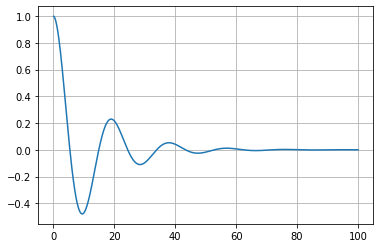

In [7]:
plt.plot(t,Data[:,32])
plt.grid()

In [8]:
zeroline = np.zeros((np.shape(x)[1],len(t)))
print(np.shape(x),np.shape(zeroline))
#pltfigure(zeroline,x,t,"Dataset","Zeroline",'dataset2.gif')

(100, 1000) (1000, 1000)


# Split The Data

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

    It ensures that chopping the data into windows of consecutive samples is still possible.
    It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.


In [9]:
n = Data.shape[1]
train_df = Data[:, 0:int(n*0.7):]
val_df = Data[:,int(n*0.7):int(n*0.9):]
test_df = Data[:,int(n*0.9):]

num_features = Data.shape[1]


# Normalize Data

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

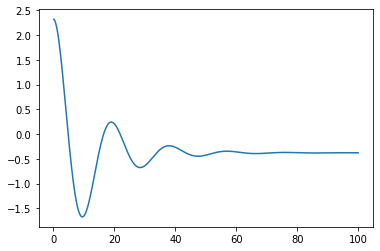

In [11]:
example_ind = 32
plt.plot(t,train_df[:,example_ind])


# Data Windowing

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df


    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}'])

  def split_window(self, data):
    inputs = tf.stack(
      [data[:,self.input_slice,i] for i in range(0,data.shape[2]) ] , axis=0
    )
    labels = tf.stack(
      [data[:,self.labels_slice,i] for i in range(0,data.shape[2]) ] , axis=0
    )

    shape = [tf.shape(inputs)[k] for k in range(3)]
    inputs = tf.reshape(inputs, [shape[0]*shape[1], shape[2], 1])
    shape = [tf.shape(labels)[k] for k in range(3)]
    labels = tf.reshape(labels, [shape[0]*shape[1], shape[2], 1])

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width,1])
    labels.set_shape([None, self.label_width,1])

    return inputs, labels

  def plot(self, model=None, plot_col='x', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n,:,:],
                label='Inputs', marker='.', zorder=-10)
      plt.scatter(self.label_indices, labels[n,:,:],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)

      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n,:],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Timesteps')

  def make_dataset(self, data,batch_size):
    data = np.array(data, dtype=np.float32)

    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data= data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size)
    ds = ds.map(self.split_window)
    return ds

  @property
  def train(self,batch_size=10):
    return self.make_dataset(self.train_df,batch_size)

  @property
  def val(self,batch_size=10):
    return self.make_dataset(self.val_df,batch_size)

  @property
  def test(self,batch_size=10):
    return self.make_dataset(self.test_df,batch_size)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result



### Example of window

In [13]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=1)
# w1.plot(lstm_model)

### Example of slicing

In [14]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size,:]),
                           np.array(train_df[100:100+w1.total_window_size,:]),
                           np.array(train_df[200:200+w1.total_window_size,:])])
example_inputs, example_labels = w1.split_window(example_window)

print('Shapes are: (batch, time, features)')
print(f'Data shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Shapes are: (batch, time, features)
Data shape: (3, 31, 70)
Inputs shape: (210, 30, 1)
Labels shape: (210, 1, 1)


### Create tf.data.Datasets

In [15]:
w1.train.element_spec

(TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

### Plot/Example

In [16]:
example_inputs, example_labels = w1.example
print(f'Inputs shape (batch, timesteps,features): {example_inputs.shape}')
print(f'Labels shape (batch, timesteps,features): {example_labels.shape}')


Inputs shape (batch, timesteps,features): (700, 30, 1)
Labels shape (batch, timesteps,features): (700, 1, 1)


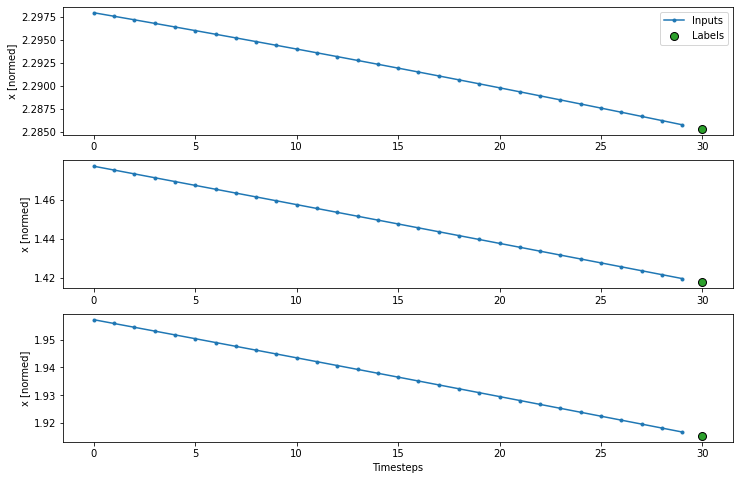

In [17]:
w1.plot()

# LSTM MODEL 1 TimeStep Train

In [18]:
def compile_and_fit(model,name, window, patience=30,MAX_EPOCHS = 500):

  now = datetime.now()
  dt_string = now.strftime("%d-%m-%Y-%H:%M")

  NAME = name +"@"+str(MAX_EPOCHS)+"@"+dt_string
  filename = os.path.join("Models",  NAME +'.h5')
  tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

  checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=0, save_best_only=True,mode = 'min')

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      batch_size=16,
                      callbacks=[early_stopping,tensorboard,checkpoint])
  return history

val_performance = {}
performance = {}

In [24]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time] => [batch, time, lstm_units]
    LSTM(256, activation='tanh', return_sequences=True,name = "LSTM1"),
    LeakyReLU(alpha=0.4,name = "LR1"),
    LSTM(256, activation='tanh', return_sequences=True,name = "LSTM2"),
    LeakyReLU(alpha=0.4,name = "LR2"),
    Flatten(name = "Flat"),
    Dense(256,activation=None, use_bias=True,name="Dense1"),
    LeakyReLU(alpha=0.4,name = "LR3"),
    Dense(units=1,name="Output")
])

In [25]:
wide_window = WindowGenerator(
    input_width=30, label_width=1, shift=1)

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (700, 30, 1)
Output shape: (700, 1)


In [26]:
%%time
history = compile_and_fit(lstm_model, "LSTM_bigger",wide_window,patience = inf)

IPython.display.clear_output()

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/500
97/97 [==============================] - 8s 51ms/step - loss: 0.0465 - mean_absolute_error: 0.0923 - val_loss: 0.0336 - val_mean_absolute_error: 0.0774
Epoch 2/500
97/97 [==============================] - 4s 40ms/step - loss: 0.0024 - mean_absolute_error: 0.0250 - val_loss: 0.0045 - val_mean_absolute_error: 0.0236
Epoch 3/500
97/97 [==============================] - 4s 40ms/step - loss: 5.4987e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0031 - val_mean_absolute_error: 0.0193
Epoch 4/500
97/97 [==============================] - 4s 40ms/step - loss: 4.8593e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0028 - val_mean_absolute_error: 0.0233
Epoch 5/500
97/97 [==============================] - 4s 40ms/step - loss: 7.5816e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0024 - val_mean_absolute_error: 0.0210
Epoch 6/500
97/97 [==============================] - 4s 40ms/step - loss: 2.2015e-04 - mean_absolute_error: 0.0083 - val_loss: 0.0035 - val_mean_absolute_error: 0.0202


KeyboardInterrupt: 

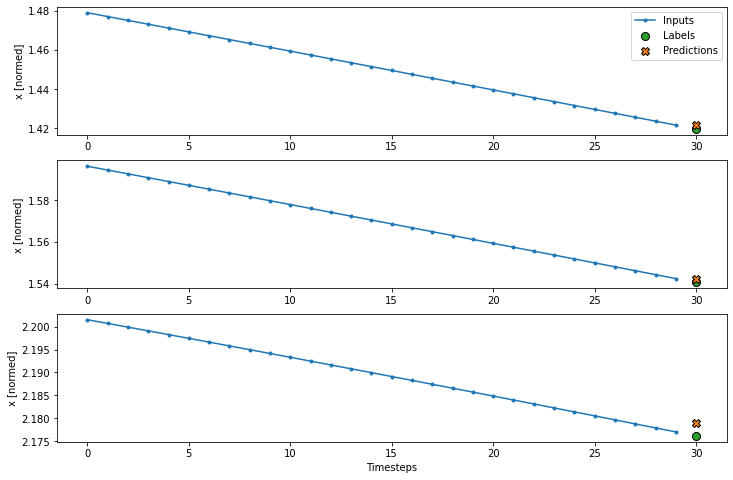

In [27]:
wide_window.plot(lstm_model)

# MULTIPLE WINDOW

Total window size: 39
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]

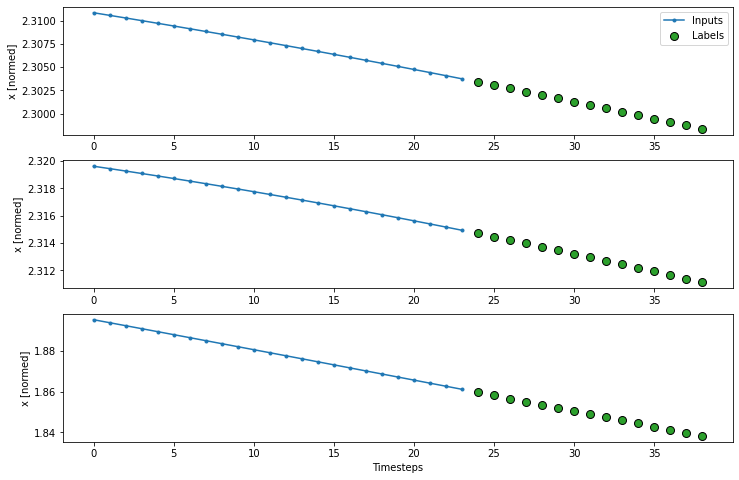

In [38]:
OUT_STEPS = 15
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [39]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units

    self.l1 = LSTM(units, activation='tanh', return_sequences=True,return_state=True,name = "LSTM1")
    self.l2 = LeakyReLU(alpha=0.4,name = "LR1")
    self.l3 = LSTM(units, activation='tanh', return_sequences=True,return_state=True,name = "LSTM2")
    self.l4 = LeakyReLU(alpha=0.4,name = "LR2")
    self.l5 = Flatten(name = "Flat")
    self.l6 = Dense(units,activation=None, use_bias=True,name="Dense1")
    self.l7 = LeakyReLU(alpha=0.4,name = "LR3")
    self.l8 = Dense(units=1,name="Output")



In [40]:
feedback_model = FeedBack(units=256, out_steps=OUT_STEPS)

In [41]:
def warmup(self, inputs):
  inp = inputs                                 #Input        => inputs.shape      => (batch, time, features)
  x, *carry_state1 = self.l1(inp) #LSTM 1       => x.shape           => (batch, timesteps,lstm_units)
  x = self.l2(x)                               #LEAKY RELU 1 => x.shape           => (batch, timesteps,lstm_units)
  x, *carry_state2  = self.l3(x)  #LSTM_2       => x.shape           => (batch, timesteps,lstm_units)
  x = self.l4(x)                               #Leaky_ReLU_2 => x.shape           => (batch, timesteps,lstm_units)
  x = self.l5(x)                               #Flatten      => x.shape           => (batch, timesteps * lstm_units)
  x = self.l6(x)                               #Dense_1      => x.shape           => (batch, lstm_units)
  x = self.l7(x)                               #Leaky_ReLU_3 => x.shape           => (batch, lstm_units)
  prediction = self.l8(x)                      #Dense_2      => predictions.shape => (batch, 1)
  
  return prediction , carry_state1 ,carry_state2

FeedBack.warmup = warmup

In [42]:
prediction, state1, state2 = feedback_model.warmup(multi_window.example[0])
print('Input shape:', multi_window.example[0].shape)
print('Output shape:', prediction.shape)

Input shape: (700, 24, 1)
Output shape: (700, 1)


In [43]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = inputs
  # Initialize the LSTM state.
  prediction, carry_state1, carry_state2 = self.warmup(inputs)
  # Insert the first prediction.
  predictions = tf.concat(axis=1, values = [predictions,tf.expand_dims(prediction,axis=2)]) # <<<< note the cast
  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    inp = predictions[:,n:,:]
    # Execute one lstm step.
    x, *carry_state1 = self.l1(inp , initial_state= [*carry_state1],
                                            training=training) #LSTM
    x = self.l2(x) #LEAKY RELU
    x, *carry_state2 = self.l3(x, initial_state= [*carry_state2], 
                                            training=training) #LSTM
    x = self.l4(x) #LEAKY RELU
    x = self.l5(x) #FLATEN
    x = self.l6(x) #DENSE/
    x = self.l7(x) #LEAKY RELU
    prediction = self.l8(x) #DENSELOL

    predictions = tf.concat(axis=1, values = [predictions,tf.expand_dims(prediction,axis=2)]) # <<<< note the cast

  # predictions.shape => (time, batch, features)
  return predictions[:,-OUT_STEPS:,:]

FeedBack.call = call

In [44]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (700, 15, 1)


In [45]:
multi_val_performance = {}
multi_performance = {}

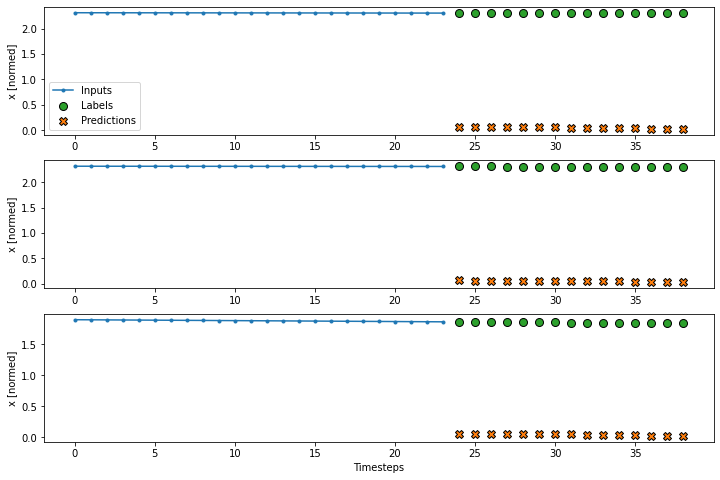

In [46]:
multi_window.plot(feedback_model)

In [47]:
%%time
history = compile_and_fit(feedback_model,
                          name="LSTM_AR100_giannos",
                          window =multi_window, 
                          patience =50, 
                          MAX_EPOCHS=500)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

Epoch 1/500


In [ ]:
multi_window.plot(feedback_model)